### Loading Data


- Reading two CSV files: games.csv and steam_200k.csv
- Defining column names for each file
- Configuring CSV read options: header=False and inferSchema=True
- Converting CSV data to DataFrames: game_df and raw_df
- Listing files in the /FileStore/tables/assignment_2 directory

In [0]:
dbutils.fs.ls("/FileStore/tables/assignment_2")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/assignment_2/Clinicaltrial_16012025.csv', name='Clinicaltrial_16012025.csv', size=205522181, modificationTime=1741354239000),
 FileInfo(path='dbfs:/FileStore/tables/assignment_2/code.html', name='code.html', size=5055, modificationTime=1742574979000),
 FileInfo(path='dbfs:/FileStore/tables/assignment_2/games.csv', name='games.csv', size=143639, modificationTime=1741354145000),
 FileInfo(path='dbfs:/FileStore/tables/assignment_2/steam_200k.csv', name='steam_200k.csv', size=8059447, modificationTime=1741354159000)]

In [0]:
columns = ['member_id', 'game', 'behavior', 'value']

raw_df = spark.read.csv(
    "/FileStore/tables/assignment_2/steam_200k.csv",
    header=False,
    inferSchema=True
).toDF(*columns)

In [0]:
columns = ['game_id', 'game']

game_df = spark.read.csv(
    "/FileStore/tables/assignment_2/games.csv", 
    header=False, inferSchema=True
).toDF(*columns)

### Exploring Data

**Viewing Schema and Data:**
- printSchema() is used to display the schema of raw_df and game_df
- show(10) is used to display the first 10 rows of raw_df and game_df

In [0]:
raw_df.printSchema()

root
 |-- member_id: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- value: double (nullable = true)



In [0]:
game_df.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- game: string (nullable = true)



In [0]:
raw_df.show(10)

+---------+--------------------+--------+-----+
|member_id|                game|behavior|value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
+---------+--------------------+--------+-----+
only showing top 10 rows



In [0]:
game_df.show(10)

+-------+--------------------+
|game_id|                game|
+-------+--------------------+
|      1|The Elder Scrolls...|
|      2|           Fallout 4|
|      3|               Spore|
|      4|   Fallout New Vegas|
|      5|       Left 4 Dead 2|
|      6|            HuniePop|
|      7|       Path of Exile|
|      8|         Poly Bridge|
|      9|         Left 4 Dead|
|     10|     Team Fortress 2|
+-------+--------------------+
only showing top 10 rows



**Data Insights:**
- Behavior distribution is analyzed to see the count of each unique behavior.
- A list of distinct games is displayed to show unique game names.
- The total number of distinct games is counted in game file.

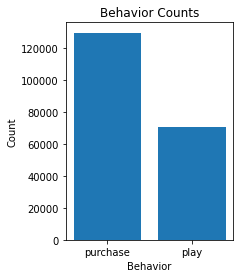

In [0]:
import matplotlib.pyplot as plt

behavior_counts = raw_df.groupBy('behavior').count().toPandas()

plt.figure(figsize=(3,4))
plt.bar(behavior_counts['behavior'], behavior_counts['count'])
plt.xlabel('Behavior')
plt.ylabel('Count')
plt.title('Behavior Counts')
plt.show()

In [0]:
raw_df.select('game').distinct().show()

+--------------------+
|                game|
+--------------------+
|       Left 4 Dead 2|
|           Fallout 4|
|Dragon Age Origin...|
|       Path of Exile|
|         Tomb Raider|
|         Left 4 Dead|
|Realm of the Mad God|
|   BioShock Infinite|
|The Elder Scrolls...|
|SEGA Genesis & Me...|
|            HuniePop|
|     The Banner Saga|
| Grand Theft Auto IV|
|Dead Island Epidemic|
|  Marvel Heroes 2015|
|             Eldevin|
|   Fallout New Vegas|
|               Spore|
|     Team Fortress 2|
|Fallout 3 - Game ...|
+--------------------+
only showing top 20 rows



In [0]:
raw_df.select('game').distinct().count()

Out[10]: 5155

#### Top 10 Most Purchased Games

In [0]:
from pyspark.sql.functions import col, count

game_purchases_df = raw_df.filter(col("behavior") == "purchase") \
    .groupBy("game") \
    .agg(count("*").alias("num_purchases")) \
    .orderBy(col("num_purchases").desc())

print("Top 10 Most Purchased Games:")
game_purchases_df.show(10)

Top 10 Most Purchased Games:
+--------------------+-------------+
|                game|num_purchases|
+--------------------+-------------+
|              Dota 2|         4841|
|     Team Fortress 2|         2323|
|            Unturned|         1563|
|Counter-Strike Gl...|         1412|
|Half-Life 2 Lost ...|          981|
|Counter-Strike So...|          978|
|       Left 4 Dead 2|          951|
|      Counter-Strike|          856|
|            Warframe|          847|
|Half-Life 2 Death...|          823|
+--------------------+-------------+
only showing top 10 rows



#### Top 10 Most Played Games

In [0]:
from pyspark.sql.functions import col, sum

raw_df = raw_df.withColumn("value", col("value").cast("float"))

game_playtime_df = raw_df.filter(col("behavior") == "play") \
    .groupBy("game") \
    .agg(sum("value").alias("total_playtime")) \
    .orderBy(col("total_playtime").desc())

print("Top 10 Most Played Games:")
game_playtime_df.show(10)

Top 10 Most Played Games:
+--------------------+------------------+
|                game|    total_playtime|
+--------------------+------------------+
|              Dota 2| 981684.6000046805|
|Counter-Strike Gl...|322771.60000587255|
|     Team Fortress 2|173673.30000534654|
|      Counter-Strike| 134261.1000032574|
|Sid Meier's Civil...| 99821.30000032485|
|Counter-Strike So...|  96075.4999980852|
|The Elder Scrolls...| 70889.30000342429|
|         Garry's Mod|49725.300001084805|
|Call of Duty Mode...|  42009.8999973014|
|       Left 4 Dead 2| 33596.70000024885|
+--------------------+------------------+
only showing top 10 rows



###Re-Structuring Data

Based on our analysis, we have selected "purchase" as the target variable for our model. This decision is driven by two key factors:

- **Data Sufficiency:** The "purchase" variable has the largest number of samples, providing a robust dataset for training our model.
- **Correlation with Engagement:** Our analysis reveals a strong correlation between game purchases and playtime. The top 10 most purchased games are also among the most played, indicating a consistent pattern of behavior.

By targeting "purchase" as our outcome variable, we aim to develop a model that can effectively predict user purchasing behavior and, by extension, inform game engagement strategies.

- A new DataFrame purchase_df is created by filtering the raw_df to include only rows where the behavior is "purchase" and the value is 1.
- Then the result confirms that the new DataFrame contains only one type of behavior.
- Taking a peak at new datframe created.

In [0]:
from pyspark.sql.functions import col

purchase_df = raw_df.filter((col("behavior") == "purchase") & (col("value") == 1))

In [0]:
purchase_df.groupBy('behavior').count().show()

+--------+------+
|behavior| count|
+--------+------+
|purchase|129511|
+--------+------+



In [0]:
purchase_df.show()

+---------+--------------------+--------+-----+
|member_id|                game|behavior|value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|               Spore|purchase|  1.0|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|            HuniePop|purchase|  1.0|
|151603712|       Path of Exile|purchase|  1.0|
|151603712|         Poly Bridge|purchase|  1.0|
|151603712|         Left 4 Dead|purchase|  1.0|
|151603712|     Team Fortress 2|purchase|  1.0|
|151603712|         Tomb Raider|purchase|  1.0|
|151603712|     The Banner Saga|purchase|  1.0|
|151603712|Dead Island Epidemic|purchase|  1.0|
|151603712|   BioShock Infinite|purchase|  1.0|
|151603712|Dragon Age Origin...|purchase|  1.0|
|151603712|Fallout 3 - Game ...|purchase|  1.0|
|151603712|SEGA Genesis & Me...|purchase|  1.0|
|151603712| Grand Theft Auto IV|purchase

- The total number of games in the games file is compared with the total number of unique games in the Steam data file.
- This comparison is done to ensure that an inner join can be performed between the two datasets, verifying that the games in the Steam data exist in the games file.

In [0]:
purchase_df.select("game").distinct().count()

Out[14]: 5155

In [0]:
merged_df = purchase_df.join(game_df, on="game", how="inner")

In [0]:
merged_df.select("game_id").distinct().count()

Out[16]: 5155

- A single user's data is extracted from the merged DataFrame to display all games associated with that person, providing a comprehensive view of the data.

In [0]:
merged_df.filter(merged_df['member_id'] == 151603712).show(n=1000,truncate=False)

+-------------------------------------------+---------+--------+-----+-------+
|game                                       |member_id|behavior|value|game_id|
+-------------------------------------------+---------+--------+-----+-------+
|The Elder Scrolls V Skyrim                 |151603712|purchase|1.0  |1      |
|Fallout 4                                  |151603712|purchase|1.0  |2      |
|Spore                                      |151603712|purchase|1.0  |3      |
|Fallout New Vegas                          |151603712|purchase|1.0  |4      |
|Left 4 Dead 2                              |151603712|purchase|1.0  |5      |
|HuniePop                                   |151603712|purchase|1.0  |6      |
|Path of Exile                              |151603712|purchase|1.0  |7      |
|Poly Bridge                                |151603712|purchase|1.0  |8      |
|Left 4 Dead                                |151603712|purchase|1.0  |9      |
|Team Fortress 2                            |1516037

### Train Test Split

- The merged DataFrame is randomly split into two subsets: a training set and a testing set.
- The training set contains 80% of the data (train_df), while the testing set contains 20% of the data (test_df).
- A seed value of 42 is used to ensure reproducibility of the split, allowing for consistent results.

In [0]:
train_df, test_df = merged_df.randomSplit([0.8, 0.2], seed=42)

### Modeling

- An Alternating Least Squares (ALS) model is created to train a matrix factorization-based recommender system.
- The ALS model is configured with the following parameters:
> -   User ID column: "member_id"
> -   Item ID column: "game_id"
> -   Rating column: "value"
> -   Cold start strategy: "drop"
> -   Non-negative ratings: True
> -   Implicit preferences: True
> -   Maximum iterations: 10
> -   Regularization parameter: 0.01
> -   Alpha parameter: 20
- The ALS model is trained on the training data (train_df) to produce a trained model.
- The trained model is used to make predictions on the testing data (test_df).
- A RegressionEvaluator is used to evaluate the performance of the model by calculating the Root Mean Squared Error (RMSE) between the predicted and actual ratings.
- The RMSE is printed to the console.

In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.01, 
    alpha=20
)

### Model Evaluation

In [0]:
model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.5363574062398491


### Hyperparameter Tuning

The table below shows the results of hyperparameter tuning for the ALS model. The goal was to find the optimal combination of parameters that yields the lowest RMSE (Root Mean Squared Error).

**Why manual Parameter tuining?**

Initially, an automated hit-and-trial approach was attempted, but it proved to be time-consuming and costly. To accelerate the process, a manual approach was adopted, where parameters were tuned based on observations and insights.

The following parameters were tuned:
- maxIter: The number of iterations was increased from 10 to 30, which resulted in a decrease in RMSE.
- regParam: The regularization parameter was increased from 0.01 to 0.1, which had a mixed effect on RMSE.
- alpha: The alpha parameter was increased from 20 to 1920, which significantly improved the RMSE.
- rank: The rank parameter was increased from 0 to 18, which had a positive effect on RMSE.
- nonnegative and implicitPrefs: These parameters were toggled between 0 and 1, which affected the RMSE.

By manually tuning these parameters based on observations, the RMSE was reduced from 0.536 to 0.100, a significant improvement. This approach allowed for faster experimentation and identification of the optimal hyperparameters.

In [0]:
from IPython.display import HTML

html_code = dbutils.fs.head('/FileStore/tables/assignment_2/code.html')

HTML(html_code)

coldStartStrategy,nonnegative,implicitPrefs,maxIter,regParam,alpha,rank,RMSE,Runtime(Sec)
drop,1,1,10,0.01,20,0,0.5363574062,25
drop,1,1,15,0.01,20,0,0.5350651466,38
drop,1,1,30,0.01,20,0,0.5318273277,200
drop,1,1,10,0.05,20,0,0.540987296,27
drop,1,1,10,0.01,60,0,0.4190641109,25
drop,1,1,10,0.01,240,0,0.3148567643,26
drop,1,1,10,0.01,960,0,0.2611170836,25
drop,1,1,10,0.01,1920,0,0.2465886665,29
drop,1,1,10,0.1,1920,15,0.2785463465,31
drop,0,0,10,0.1,1920,15,0.1007530999,20


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=30, 
    regParam=0.01, 
    alpha=20
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.5318273278856753


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.05, 
    alpha=20
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.5409872960215799


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.01, 
    alpha=60
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.41906411090660894


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.01, 
    alpha=240
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.31485676433893667


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.01, 
    alpha=960
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.2611170836851742


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value", 
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.01, 
    alpha=1920
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.2465886657946328


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value",
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=True,
    maxIter=10, 
    regParam=0.1, 
    rank=15, 
    alpha=1920
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.27854634777575704


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value",
    coldStartStrategy="drop",
    nonnegative=False,
    implicitPrefs=False,
    maxIter=10, 
    regParam=0.1, 
    rank=15, 
    alpha=1920
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.10075309993860049


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als_model = ALS(
    userCol="member_id", 
    itemCol="game_id", 
    ratingCol="value",
    coldStartStrategy="drop",
    nonnegative=False,
    implicitPrefs=False,
    maxIter=10, 
    regParam=0.1, 
    rank=18, 
    alpha=1920
)

model = als_model.fit(train_df)

predictions = model.transform(test_df)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="value", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.10054845306959367


### Exploratory Testing 

The purpose of this Exploratory Testing is to evaluate the performance of a recommendation model by selecting a random member and analyzing the model's recommendations for that member. This approach allows for a qualitative assessment of the model's accuracy and relevance.
Effectiveness compared to RMSE:
- RMSE (Root Mean Squared Error) is a quantitative metric that measures the difference between predicted and actual ratings. While RMSE provides a numerical evaluation of the model's performance, it has some limitations:
- RMSE does not provide insight into the quality of the recommendations.
- RMSE can be influenced by outliers or biased data.

#### For Random Choosen One

In [0]:
from pyspark.sql.functions import rand

random_member = merged_df.select("member_id").distinct().orderBy(rand()).first()
random_member_id = random_member.member_id

member_purchases = merged_df.filter(col("member_id") == random_member_id)

print("Games Purchased by Member:")
member_purchases.select("game").show()

Games Purchased by Member:
+--------------------+
|                game|
+--------------------+
|      Counter-Strike|
|       Day of Defeat|
|            NBA 2K15|
|Call of Duty Blac...|
|Call of Duty Blac...|
|           Robocraft|
|       Left 4 Dead 2|
|          Dino D-Day|
|           Half-Life|
|            Ricochet|
|Counter-Strike Ne...|
|  Deathmatch Classic|
|Half-Life 2 Death...|
|Half-Life 2 Lost ...|
|Half-Life Blue Shift|
|Half-Life Opposin...|
|Team Fortress Cla...|
+--------------------+



In [0]:
member_recommendations = model.transform(merged_df.filter(col("member_id") == random_member_id))

member_recommendations = member_recommendations.orderBy(col("prediction").desc())

print("\nTop 5 Recommended Games for Member:")
member_recommendations.select("game","prediction").show(5)


Top 5 Recommended Games for Member:
+--------------------+----------+
|                game|prediction|
+--------------------+----------+
|           Robocraft| 0.8997473|
|Counter-Strike Ne...|0.89974135|
|            NBA 2K15| 0.8997261|
|       Left 4 Dead 2| 0.8996839|
|      Counter-Strike| 0.8996531|
+--------------------+----------+
only showing top 5 rows



The output of the Exploratory Testing shows:
- The games purchased by the selected member.
- The top 5 recommended games for the member, ranked by the model's prediction score.

The output is good because:
- The recommended games are relevant to the member's purchase history.
- The model is able to identify patterns in the member's behavior and provide personalized recommendations.

### General Recommendations 

#### For All Users

- Create a dataset with all possible member-game combinations: The code generates a dataset containing all possible combinations of members and games.
- Make predictions using the trained ALS model: The trained ALS model is used to make predictions on the dataset of all possible member-game combinations.
- Rank recommendations by prediction score: The predictions are ranked in descending order based on their prediction scores.
- Display top recommendations: The top recommendations are displayed, showing the member ID, game ID, and prediction score.
- Generate general recommendations for any person: The code provides general recommendations that can be applied to any person, without requiring their specific rating history.

In [0]:
all_members = train_df.select("member_id").distinct()
all_games = train_df.select("game_id", "game").distinct()

all_combinations = all_members.crossJoin(all_games)

general_recommendations = model.transform(all_combinations)

general_recommendations = general_recommendations.orderBy(col("prediction").desc())

print("Top 10 General Recommendations:")
general_recommendations.select("member_id", "game_id", "game", "prediction").show(10)

Top 10 General Recommendations:
+---------+-------+--------------------+----------+
|member_id|game_id|                game|prediction|
+---------+-------+--------------------+----------+
| 62985928|   3301|Season of Mystery...| 0.9046717|
| 62985928|   1442|Tom Clancy's Ghos...| 0.9045555|
|213854339|   1442|Tom Clancy's Ghos...| 0.9042737|
|213854339|   2659|             NBA 2K9| 0.9041987|
| 61444633|   1442|Tom Clancy's Ghos...| 0.9041111|
| 62985928|   5053|Midnight Mysterie...| 0.9040186|
| 62985928|   5058|Samantha Swift an...| 0.9040186|
|131130328|   5053|Midnight Mysterie...|0.90396327|
|131130328|   5058|Samantha Swift an...|0.90396327|
|131130328|   2336|   The Clockwork Man|0.90388155|
+---------+-------+--------------------+----------+
only showing top 10 rows

